<a href="https://colab.research.google.com/github/reneejiang/Ion_transition_events_poisson_distribution/blob/master/myPiezo_ion_transition_uncertanities.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

import sys
import os
import tqdm
import gc
import copy

from collections import defaultdict
import itertools

import plotly as ply
ply.io.renderers.default="notebook"

import ipywidgets as widgets
from ipywidgets import interact

import gspread
import pandas as pd
from google.colab import auth
from oauth2client.client import GoogleCredentials

import gspread
import pandas as pd
from google.colab import auth
from oauth2client.client import GoogleCredentials

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
!pip install --upgrade -q gspread

In [ ]:
!pip install 'google-auth==1.7.2'

In [1]:
#auth.authenticate_user()
#gc = gspread.authorize(GoogleCredentials.get_application_default())
!pwd
#worksheet = pd.read_csv('potTrans.csv')
#worksheet

/content


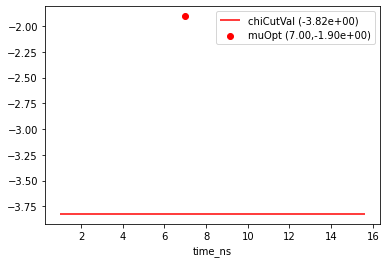

0      5.2
1      6.7
2     13.6
3      3.1
4      6.4
      ... 
63     3.7
64     2.3
65    15.6
66     7.1
67     3.0
Name: time_ns, Length: 68, dtype: float64

In [ ]:
muOpt=7.0
muVals=muOpt*np.exp(np.linspace(-2,1,19))
muVals=worksheet['time_ns']
meanMu=np.mean(worksheet['time_ns'])
l0=sp.stats.poisson.logpmf(int(muOpt),muOpt)
sns.lineplot(muVals,sp.stats.poisson.logpmf(meanMu,muVals))
chiCutVal=l0-3.84/2.0
plt.hlines(y=chiCutVal,
           xmin=np.min(muVals),xmax=np.max(muVals),
           label='chiCutVal (%.2e)'%chiCutVal,color='r')
plt.scatter(x=muOpt,y=l0,c='r',label='muOpt (%.2f,%.2e)'%(muOpt,l0))
plt.legend()
plt.show()
muVals

In [ ]:
def lR_interval(X,alpha,verbose=False):
  nX=len(X)
  theta0=np.sum(X)*1.
  l0=sp.stats.poisson.logpmf(theta0,theta0)
  chiCut=sp.stats.chi2.ppf(1-alpha,1)
  if theta0 > 0:
    min_theta=sp.optimize.root(
        lambda theta: 2*(l0-sp.stats.poisson.logpmf(theta0,*theta))-chiCut,
        x0=[theta0/2.]).x[0]/nX
  else:
    min_theta=0
  max_theta=sp.optimize.root(
      lambda theta: 2*(l0-sp.stats.poisson.logpmf(theta0,*theta))-chiCut,
      x0=[theta0*2.]).x[0]/nX
  if verbose:
    print('nX:',nX,'; theta0:',theta0,'; chiCut:',chiCut,'; l0:',l0)
  return(min_theta,max_theta)


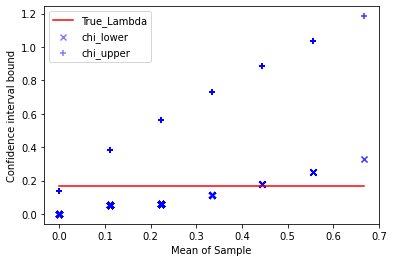

chiCI bound success: 0.721


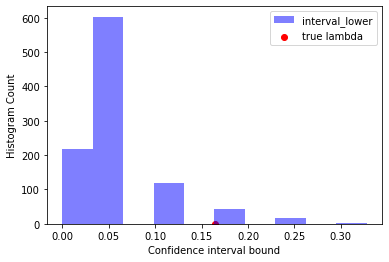

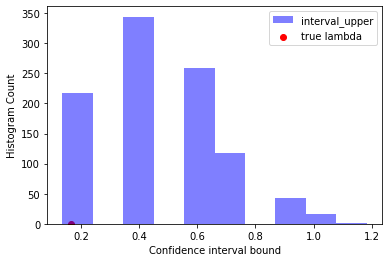

In [ ]:
intervalData=[]
estData=[]
aVal=0.12
trueLambda=0.16444
nSamples=9
nTests=1000
for ii in np.arange(nTests):
  tempDat=sp.stats.poisson(mu=trueLambda).rvs(size=nSamples)
  intervalData.append(np.array(lR_interval(tempDat,aVal)))
  estData.append(np.mean(tempDat))

intervalData=np.array(intervalData)
#print(intervalData)


plt.scatter(estData,intervalData[:,0],c='b',marker='x',
            alpha=.5,label='chi_lower')
plt.scatter(estData,intervalData[:,1],c='b',marker='+',
            alpha=.5,label='chi_upper')
plt.plot([np.min(estData),np.max(estData)],
         [trueLambda,trueLambda],c='r',label='True_Lambda')
plt.xlabel('Mean of Sample')
plt.ylabel("Confidence interval bound")
plt.legend()
plt.show()
print('chiCI bound success:',
      np.mean((intervalData[:,0]<=trueLambda) * (intervalData[:,1]>=trueLambda)))

plt.hist(intervalData[:,0],color='blue',alpha=.5,label='interval_lower')
plt.scatter(x=trueLambda,y=0,c='red',label='true lambda')
plt.legend()
plt.xlabel('Confidence interval bound')
plt.ylabel('Histogram Count')
plt.show()

plt.hist(intervalData[:,1],color='blue',alpha=.5,label='interval_upper')
plt.scatter(x=trueLambda,y=0,c='red',label='true lambda')
plt.legend()
plt.xlabel('Confidence interval bound')
plt.ylabel('Histogram Count')
plt.show()

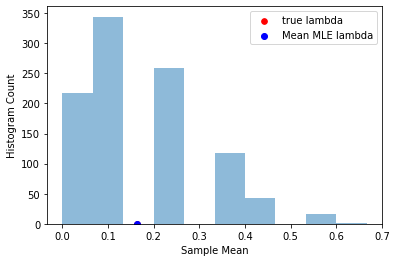

Mean MLE lambda = 0.16444444444444445


In [ ]:
plt.hist(estData,alpha=.5)
plt.scatter(x=trueLambda,y=0,c='r',label='true lambda',s=32)
plt.scatter(x=np.mean(estData),y=0,c='blue',label='Mean MLE lambda')
plt.legend()
plt.xlabel('Sample Mean')
plt.ylabel('Histogram Count')
plt.show()
print('Mean MLE lambda =',np.mean(estData))
#print(estData)

(11, 3)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



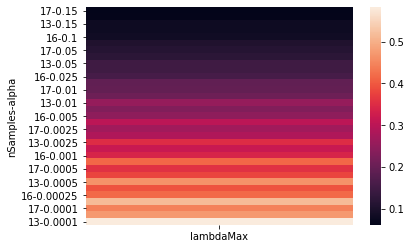

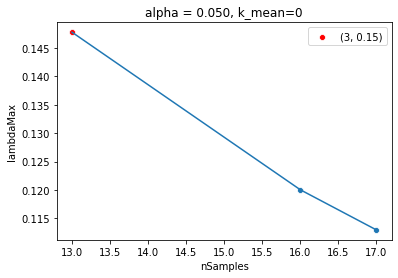

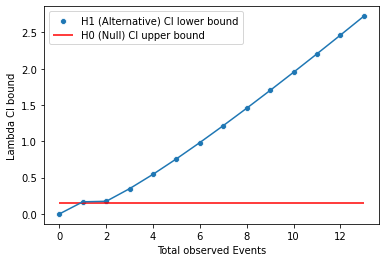

   nSamples  alpha  lambdaMax
6        17   0.05   0.112984
7        16   0.05   0.120046
8        13   0.05   0.147748
0.14774841618054324


In [ ]:
#sampleSizes=np.arange(16)+1
alphaVals=np.array([.15,.1,.05,.025,.01,.005,.0025,.001,.0005,.00025,.0001])
sampleSizes=np.array([17,16,13])
#alphaVals=np.array([0.13])
countGrid,alphaGrid=np.meshgrid(sampleSizes,alphaVals)
gridShape=np.shape(countGrid)
print(gridShape)
lambdaMaxGrid=np.zeros(shape=gridShape)

# nSamples= number of trials

with tqdm.tqdm_notebook(
      total=np.product(gridShape),
      desc='computing lambda grid'
    ) as pbar:
  for ii in np.arange(gridShape[0]):
    for jj in np.arange(gridShape[1]):
      lambdaMaxGrid[ii,jj]=lR_interval(
          np.zeros(countGrid[ii,jj]),
          alphaGrid[ii,jj])[1]
      pbar.update()

lambdaData=pd.DataFrame({
      "nSamples":countGrid.flatten(),
      "alpha":alphaGrid.flatten(),
      "lambdaMax":lambdaMaxGrid.flatten()
  })
sns.heatmap(data=lambdaData.set_index(['nSamples','alpha']))
plt.show()

plotData=lambdaData.query('alpha == 0.05')
sns.lineplot(x=plotData.nSamples,y=plotData.lambdaMax)
sns.scatterplot(x=plotData.nSamples,y=plotData.lambdaMax)
sns.scatterplot(x=[plotData.query('nSamples==13').nSamples.to_numpy()[0]],
                y=[plotData.query('nSamples==13').lambdaMax.to_numpy()[0]],
                color=['red'],
                label='(%g, %.2f)'%(3,plotData.query(
                    'nSamples==13').lambdaMax.to_numpy()[0]))
plt.title('alpha = %.3f, k_mean=0'%.05)
plt.show()


kSums=np.arange(14)
ci_lowers=np.array(
    [lR_interval(
        np.concatenate([[kSum],[0]*2]),aVal)[0] \
     for kSum in kSums])
sns.lineplot(kSums,ci_lowers)
sns.scatterplot(kSums,ci_lowers,
                label='H1 (Alternative) CI lower bound')
plt.hlines(y=plotData.query('nSamples==13').lambdaMax.to_numpy()[0],
           xmin=np.min(kSums),xmax=np.max(kSums),
           color='red',
           label='H0 (Null) CI upper bound')
plt.xlabel('Total observed Events')
plt.ylabel('Lambda CI bound')
plt.legend()
plt.show()

print(plotData)
print(plotData.query('nSamples==13').lambdaMax.to_numpy()[0])

In [4]:
!pwd
#worksheet = pd.read_csv('potTrans.csv')


/content


In [5]:
def lR_interval(X,alpha,verbose=False):
  nX=len(X)
  theta0=np.sum(X)*1.
  l0=sp.stats.poisson.logpmf(theta0,theta0)
  chiCut=sp.stats.chi2.ppf(1-alpha,1)
  if theta0 > 0:
    min_theta=sp.optimize.root(
        lambda theta: 2*(l0-sp.stats.poisson.logpmf(theta0,*theta))-chiCut,
        x0=[theta0/2.]).x[0]/nX
  else:
    min_theta=0
  max_theta=sp.optimize.root(
      lambda theta: 2*(l0-sp.stats.poisson.logpmf(theta0,*theta))-chiCut,
      x0=[theta0*2.]).x[0]/nX
  if verbose:
    print('nX:',nX,'; theta0:',theta0,'; chiCut:',chiCut,'; l0:',l0)
  return(min_theta,max_theta)


In [8]:
#sampleSizes=np.arange(16)+1
#alphaVals=np.array([.15,.1,.05,.025,.01,.005,.0025,.001,.0005,.00025,.0001])

########## POT ions for PIEZO!!!!!!!!!!!!!!!
nSdata={
  'S1':np.array([16,13]), # -750mV
  'S2':np.array([10,2]) , # -500mV
  'S3':np.array([1,3]) , # -250mV
  'S4':np.array([5,2]) , #  250mV
  'S5':np.array([13,5]) , #  500mV
  'S6':np.array([24,49])  #  750mV
}
# nSamples= number of trials

aVal=0.15
#print(sampleSizes)
for sampleSizes in nSdata.keys():
  #print(sampleSizes)
  min,max=lR_interval(nSdata[sampleSizes],aVal)
  print(min,max)


10.961345943790624 18.728856535096263
3.8393955131812834 8.850033079326545
0.8830725772847483 3.803735654415513
1.924226420568271 5.764262725529932
6.28145201514436 12.408416315094549
30.690734779498005 42.99979773387892


In [10]:
#sampleSizes=np.arange(16)+1
#alphaVals=np.array([.15,.1,.05,.025,.01,.005,.0025,.001,.0005,.00025,.0001])

########## CLA ions for PIEZO!!!!!!!!!!!!!!!
nSdata={
  'S1':np.array([1,2]), # -750mV
  'S2':np.array([2,0]) , # -500mV
  'S3':np.array([0,0]) , # -250mV
  'S4':np.array([5,3]) , #  250mV
  'S5':np.array([7,2]) , #  500mV
  'S6':np.array([22,41])  #  750mV
}
# nSamples= number of trials

aVal=0.15
#print(sampleSizes)
for sampleSizes in nSdata.keys():
  #print(sampleSizes)
  min,max=lR_interval(nSdata[sampleSizes],aVal)
  print(min,max)



0.5720366022560304 3.1134735535523554
0.2940469777239198 2.3888926434129356
0 0.5180627139555483
2.2939013813859583 6.39486918623596
2.6713613066070905 7.017628389871206
26.12706425941389 37.56343370514196


In [13]:
#sampleSizes=np.arange(16)+1
#alphaVals=np.array([.15,.1,.05,.025,.01,.005,.0025,.001,.0005,.00025,.0001])

########## POT ions for PIEZO!!!!!!!!!!!!!!!
nSdata={
  'S2':np.array([6,3,3]) , # -500mV
}
# nSamples= number of trials

aVal=0.15
#print(sampleSizes)
for sampleSizes in nSdata.keys():
  #print(sampleSizes)
  min,max=lR_interval(nSdata[sampleSizes],aVal)
  print(min,max)



2.5595970087875224 5.900022052884363


In [14]:

########## CLA ions for PIEZO!!!!!!!!!!!!!!!
nSdata={
  'S2':np.array([2,0,0]) , # -500mV
}
# nSamples= number of trials

aVal=0.15
#print(sampleSizes)
for sampleSizes in nSdata.keys():
  #print(sampleSizes)
  min,max=lR_interval(nSdata[sampleSizes],aVal)
  print(min,max)

0.1960313184826132 1.5925950956086237


In [15]:
#sampleSizes=np.arange(16)+1
#alphaVals=np.array([.15,.1,.05,.025,.01,.005,.0025,.001,.0005,.00025,.0001])

########## POT ions for PIEZO!!!!!!!!!!!!!!!
nSdata={
  'S2':np.array([1,0]) , # -500mV
}
# nSamples= number of trials

aVal=0.15
#print(sampleSizes)
for sampleSizes in nSdata.keys():
  #print(sampleSizes)
  min,max=lR_interval(nSdata[sampleSizes],aVal)
  print(min,max)


0.25 1.5994735880595987
